# Keras integration

TODO: Some explanation...

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import gpflux
from gpflow.ci_utils import ci_niter

import matplotlib.pyplot as plt

2022-04-06 13:27:14.040229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-04-06 13:27:14.040272: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.keras.backend.set_floatx("float64")

In [3]:
%matplotlib inline

In [4]:
d = np.load("../../tests/snelson1d.npz")
X, Y = d["X"], d["Y"]
num_data, input_dim = X.shape
_, output_dim = Y.shape

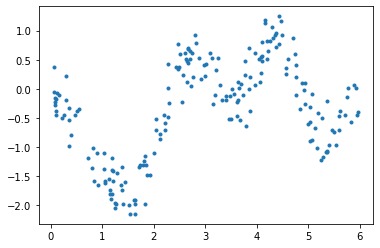

In [5]:
plt.figure()
plt.plot(X, Y, ".")
plt.show()

In [6]:
def create_layers():
    num_inducing = 13
    hidden_dim = 1
    Z = np.linspace(X.min() - 0.1, X.max() + 0.1, num_inducing).reshape(-1, 1)

    layer1 = gpflux.helpers.construct_gp_layer(
        num_data, num_inducing, input_dim, hidden_dim, z_init=Z.copy()
    )
    layer1.mean_function = gpflow.mean_functions.Identity()  # TODO: pass layer_type instead
    layer1.q_sqrt.assign(layer1.q_sqrt * 0.01)

    layer2 = gpflux.helpers.construct_gp_layer(
        num_data, num_inducing, hidden_dim, output_dim, z_init=Z.copy()
    )

    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.01))

    return layer1, layer2, likelihood_layer

In [7]:
def create_model(model_class):
    """
    We pass in `model_class` to make it easy to use
    `gpflux.optimization.NatGradModel`, which is required for combining
    GPflow's `NaturalGradient` optimizer with Keras. `model_class` needs to be
    a constructor that has the same semantics as `tf.keras.Model.__init__`.
    """
    layer1, layer2, likelihood_layer = create_layers()
    dgp = gpflux.models.DeepGP([layer1, layer2], likelihood_layer, default_model_class=model_class)
    return dgp

In [8]:
batch_size = 2
num_epochs = ci_niter(200)

In [9]:
dgp = create_model(tf.keras.Model)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",
        patience=5,
        factor=0.95,
        verbose=1,
        min_lr=1e-6,
    )
]

dgp_train = dgp.as_training_model()
dgp_train.compile(tf.optimizers.Adam(learning_rate=0.1))

history = dgp_train.fit(
    {"inputs": X, "targets": Y}, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks
)

2022-04-06 13:27:16.645927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-04-06 13:27:16.645958: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 13:27:16.645979: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az121-341): /proc/driver/nvidia/version does not exist
2022-04-06 13:27:16.646297: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/hostedtoolcache/Python/3.7.12/x64/li

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-04-06 13:27:17.034675: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-04-06 13:27:17.771428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-06 13:27:17.771809: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2593905000 Hz


Epoch 1/2


  1/100 [..............................] - ETA: 6:42 - loss: 128.4416 - gp_layer_prior_kl: 0.2668 - gp_layer_1_prior_kl: 0.0000e+00

 34/100 [=========>....................] - ETA: 0s - loss: 19.4630 - gp_layer_prior_kl: 0.1001 - gp_layer_1_prior_kl: 0.0724       

 70/100 [====================>.........] - ETA: 0s - loss: 11.3938 - gp_layer_prior_kl: 0.0891 - gp_layer_1_prior_kl: 0.0957

100/100 [==============================] - 4s 1ms/step - loss: 8.3814 - gp_layer_prior_kl: 0.0791 - gp_layer_1_prior_kl: 0.0960


Epoch 2/2
  1/100 [..............................] - ETA: 0s - loss: 0.4865 - gp_layer_prior_kl: 0.0631 - gp_layer_1_prior_kl: 0.0950

 36/100 [=========>....................] - ETA: 0s - loss: 1.3236 - gp_layer_prior_kl: 0.0609 - gp_layer_1_prior_kl: 0.0918

 69/100 [===================>..........] - ETA: 0s - loss: 1.1721 - gp_layer_prior_kl: 0.0605 - gp_layer_1_prior_kl: 0.0907

100/100 [==============================] - 0s 1ms/step - loss: 1.0222 - gp_layer_prior_kl: 0.0616 - gp_layer_1_prior_kl: 0.0896


In [10]:
dgp_natgrad = create_model(gpflux.optimization.NatGradModel)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",
        patience=5,
        factor=0.95,
        verbose=1,
        min_lr=1e-6,
    )
]

dgp_natgrad_train = dgp_natgrad.as_training_model()
dgp_natgrad_train.natgrad_layers = (
    True  # we want all (here two) GPLayer instances trained by NaturalGradient
)
# alternatively, we could set `natgrad_layers` explicitly to the GPLayer instances inside the model
dgp_natgrad_train.compile(
    [
        gpflow.optimizers.NaturalGradient(gamma=0.05),
        gpflow.optimizers.NaturalGradient(gamma=0.05),
        tf.optimizers.Adam(learning_rate=0.1),
    ]
)

history_natgrad = dgp_natgrad_train.fit(
    {"inputs": X, "targets": Y}, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks
)

/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  


Epoch 1/2


Executing NatGradModel backwards pass


Executing NatGradModel backwards pass


  1/100 [..............................] - ETA: 5:41 - loss: 50.5338 - gp_layer_2_prior_kl: 0.2668 - gp_layer_3_prior_kl: 0.0000e+00

 35/100 [=========>....................] - ETA: 0s - loss: 10.7646 - gp_layer_2_prior_kl: 0.2667 - gp_layer_3_prior_kl: 0.0175      

 70/100 [====================>.........] - ETA: 0s - loss: 6.4848 - gp_layer_2_prior_kl: 0.2665 - gp_layer_3_prior_kl: 0.0217 

100/100 [==============================] - 4s 1ms/step - loss: 5.0196 - gp_layer_2_prior_kl: 0.2664 - gp_layer_3_prior_kl: 0.0239


Epoch 2/2
  1/100 [..............................] - ETA: 0s - loss: 1.6543 - gp_layer_2_prior_kl: 0.2660 - gp_layer_3_prior_kl: 0.0298



 35/100 [=========>....................] - ETA: 0s - loss: 1.2936 - gp_layer_2_prior_kl: 0.2658 - gp_layer_3_prior_kl: 0.0306

 68/100 [===================>..........] - ETA: 0s - loss: 1.2247 - gp_layer_2_prior_kl: 0.2657 - gp_layer_3_prior_kl: 0.0314

100/100 [==============================] - ETA: 0s - loss: 1.2306 - gp_layer_2_prior_kl: 0.2655 - gp_layer_3_prior_kl: 0.0320

100/100 [==============================] - 0s 2ms/step - loss: 1.2306 - gp_layer_2_prior_kl: 0.2655 - gp_layer_3_prior_kl: 0.0320


In [11]:
dgp_test = dgp.as_prediction_model()
res = dgp_test(X)

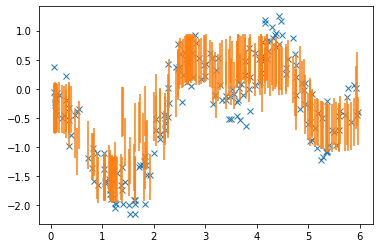

In [12]:
plt.plot(X, Y, "x")
plt.errorbar(X.squeeze(), np.squeeze(res.y_mean), np.sqrt(np.squeeze(res.y_var)), ls="")
plt.show()

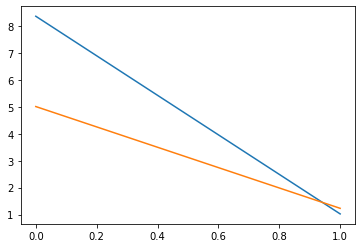

In [13]:
plt.plot(history.history["loss"], label="Adam")
plt.plot(history_natgrad.history["loss"], label="NatGrad")
plt.show()